<a href="https://colab.research.google.com/github/lorenzozanisi/recommenderSystems/blob/master/NeuMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.models import Model

In [174]:
!wget 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!unzip ml-100k.zip

--2021-02-26 22:45:38--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.1MB/s    in 0.3s    

2021-02-26 22:45:38 (16.1 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [175]:
import pandas as pd
data = pd.read_csv('ml-100k/u.data', sep='\t', names=['userID','itemID','rating','timestamp'])
data = data.drop(columns='timestamp')


In [177]:
data.head(10)

,userID,itemID,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
5,298,474,4
6,115,265,2
7,253,465,5
8,305,451,3
9,6,86,3


In [148]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(data,test_size=0.2)

train_val_split = 0.2
Nval = int(len(train)*train_val_split)

val = train.loc[:Nval,:]
val_labels = val.pop('rating')

train = train.loc[Nval:,:]
train_labels = train.pop('rating')


trainset = tf.data.Dataset.from_tensor_slices((dict(train), train_labels)).shuffle(buffer_size=len(train)).batch(32)
validset = tf.data.Dataset.from_tensor_slices((dict(val), val_labels)).batch(32)

In [116]:
# adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x,y: tf.expand_dims(x[name],-1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature


In [136]:
#preprocess withone hot encoding
user = Layers.Input(shape=(1,),name='userID')
item = Layers.Input(shape=(1,),name='itemID')
user_encoded = encode_integer_categorical_feature(user, "userID", trainset)
item_encoded = encode_integer_categorical_feature(item, "itemID", trainset)



In [150]:
MF_embedding_size = 64
MLP_embedding_size = 128


#GMF branch

embed_MF_user = Layers.Dense(MF_embedding_size)(user_encoded)
embed_MF_item = Layers.Dense(MF_embedding_size)(item_encoded)
GMF = Layers.Dot(axes=(1))([embed_MF_user, embed_MF_item])

Dense_user = Layers.Dense(MLP_embedding_size)(user_encoded)
Dense_item = Layers.Dense(MLP_embedding_size)(item_encoded)
concatenate_1 = Layers.concatenate([Dense_user, Dense_item])

d1 = Layers.Dense(128, activation='relu')(concatenate_1)
d2 = Layers.Dense(128, activation='relu')(d1)
d3 = Layers.Dense(64, activation='relu')(d2)

NeuMF = Layers.concatenate([d3,GMF])

prediction = Layers.Dense(1)(NeuMF)



In [151]:
import numpy as np

all_inputs = Layers.concatenate([user_encoded,item_encoded])
m = Model([user,item], NeuMF)
m.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
          loss='mean_squared_error' )


In [152]:
history = m.fit(trainset, epochs=10, validation_data=validset)

Epoch 1/10
762/762 [==============================] - 9s 11ms/step - loss: 3.1981 - val_loss: 1.1683
Epoch 2/10
762/762 [==============================] - 8s 11ms/step - loss: 1.1099 - val_loss: 1.1594
Epoch 3/10
762/762 [==============================] - 8s 10ms/step - loss: 0.9217 - val_loss: 1.0260
Epoch 4/10
762/762 [==============================] - 8s 11ms/step - loss: 0.8684 - val_loss: 0.9746
Epoch 5/10
762/762 [==============================] - 8s 10ms/step - loss: 0.8313 - val_loss: 0.9454
Epoch 6/10
762/762 [==============================] - 8s 10ms/step - loss: 0.8250 - val_loss: 0.9539
Epoch 7/10
762/762 [==============================] - 8s 10ms/step - loss: 0.7847 - val_loss: 0.9565
Epoch 8/10
762/762 [==============================] - 8s 10ms/step - loss: 0.7374 - val_loss: 1.0138
Epoch 9/10
762/762 [==============================] - 8s 10ms/step - loss: 0.6910 - val_loss: 0.9944
Epoch 10/10
762/762 [==============================] - 8s 11ms/step - loss: 0.6469 - val_lo

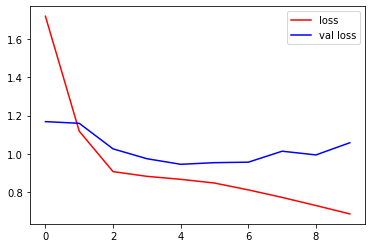

In [159]:
import matplotlib.pylab as plt
epoch = np.arange(10)
plt.plot(epoch,history.history['loss'],color='red', label='loss')
plt.plot(epoch,history.history['val_loss'],color='blue', label='val loss')
plt.legend()